In [2]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb


## setup

In [3]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [4]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run4_generalization'

## error tick 
## confusion 
## snapshot of round 1 and by round 8, along the diagonal - pattern of success and failures - representing accuracy invarious ways 
## pixel intensity 
## pipeline for stats - old R markdown notebook - elmer R markdown in analysis archive - mixed effects model 
## interaction pre post between repeated and control 
## svg annoation - expectation of what the - set up stats modeling pipeline 
## tangrams paper - analogous interesting things 

In [5]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

854 stroke records in the database.
160 clickedObj records in the database.


In [6]:
S = coll.find({ '$and': [{'eventType': 'stroke'},{'workerID': 'A1V2P0JYPD7GM6'}]}).sort('time')
C = coll.find({ '$and': [{'eventType': 'clickedObj'},{'workerID': 'A1V2P0JYPD7GM6'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

0 stroke records in the database.
0 clickedObj records in the database.


## generate group dataframe

In [7]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano 

In [8]:
reload(h)
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
complete_games = h.get_complete_and_valid_games(games,coll,iterationName,researchers=researchers, tolerate_undefined_worker=False)

There was something wrong with this game 5976-3520ab05-033f-4cda-bb7f-8d93ab0956c4
There was something wrong with this game 0135-deee0e88-ce5a-48b1-99d5-cf1e3217a99f
There was something wrong with this game 4004-08fcac10-54da-4362-8b77-6869a2b4aa0a
There was something wrong with this game 5288-2608bf5a-2af4-438c-90df-032a479b3195
There was something wrong with this game 2153-fe370c60-795f-46f4-959e-4aa70ec7c4ed
There was something wrong with this game 2306-68150396-3082-458b-bf35-5683428df704
There was something wrong with this game 5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9
There was something wrong with this game 2909-8200b9a1-435f-4c08-b71b-04bd71508910
There was something wrong with this game 8283-9b48bed2-3a8c-45ae-b706-649231363252
There was something wrong with this game 5428-1c065c92-f2c0-4c0f-bf37-9a7bc82fb832
There was something wrong with this game 1602-f09f5dc8-0f6a-46ab-9e09-ab12c700e9b5
There was something wrong with this game 3775-8f131e6c-5ac4-43ad-b290-c09b11dde8fa
Ther

In [9]:
## check if emailed workers submitted data
for i, game in enumerate(complete_games):
    num_clicks = coll.find({'$and': [{'gameid':game},{'eventType':'clickedObj'},{'iterationName':iterationName}]}).count()
    ## check to make sure there were two real mturk workers participating who were not researchers
    real_workers = False
    viewer = coll.find({'$and': [{'gameid':game},{'eventType':'clickedObj'},{'iterationName':iterationName}]}).distinct('workerId')
    sketcher = coll.find({'$and': [{'gameid':game},{'eventType':'stroke'},{'iterationName':iterationName}]}).distinct('workerId')
    if viewer == 'A1V2P0JYPD7GM6' or sketcher == 'A1V2P0JYPD7GM6':
        print "A1V2P0JYPD7GM6 did complete HIT"
    if viewer == 'A6FE2ZQNFW12V' or sketcher == 'A6FE2ZQNFW12V':
        print "A6FE2ZQNFW12V did complete HIT"

In [10]:
reload(h)

# preprocessing 

TrialNum = []
GameID = []
Condition = []
Target = []
Category = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
Phase = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = [] #accuracy (True or False)
png=[] # the sketch 
timedOut=[] # True if sketchers didn't draw anything, False o.w.
meanPixelIntensity=[]

_complete_games=['7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82', '5761-d75d770d-0013-4ba0-8d4f-7f4a635109d9', '3176-1391c021-32cc-4034-8811-4ddafef4280f', 
                 '1217-816328d8-5486-410a-b18e-9578493b0f31', 
'1555-977bf072-b352-44e5-b00e-317349ddc158', '3663-5a7299be-30cf-4686-939e-b2f163df6889', '9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993' '8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73', 
'9340-a1124706-24cc-44f3-9097-ba0b33adbf36', '3511-727c76f4-f755-48e9-8fc8-b61efbe785c9']
for i,g in enumerate(complete_games):
        print 'Analyzing game {} | {} of {}: '.format(g, i, len(complete_games))

        # collection of all clickedObj events in a particular game 
        X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
        # collection of all stroke events in a particular game 
        Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

        for t in X: # for each clickedObj event
            targetname = t['intendedName']
            category = h.OBJECT_TO_CATEGORY_run2[targetname]
            Phase.append(t['phase'])
            Repetition.append(t['repetition'])
            distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
            full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
            png.append(t['pngString'])

            #for each stroke event with same trial number as this particular clickedObj event 
            y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
            # have to account for cases in which sketchers do not draw anything 
            if (y.count() == 0):
                numStrokes.append(float('NaN'))
                drawDuration.append(float('NaN'))
                svgStringLength.append(float('NaN'))
                svgStringLengthPerStroke.append(float('NaN'))
                numCurvesPerSketch.append(float('NaN'))
                numCurvesPerStroke.append(float('NaN'))
                svgStringStd.append(float('NaN'))
                meanPixelIntensity.append('NaN')
                timedOut.append(True)
            else: 
                # calculate numStrokes 
                lastStrokeNum = float(y[y.count() - 1]['currStrokeNum']) # get currStrokeNum at last stroke
#                 numStrokes.append(lastStrokeNum)
                ns = y.count()
                assert lastStrokeNum == ns
                numStrokes.append(ns)
                
                # calculate drawDuration 
                startStrokeTime =  float(y[0]['startStrokeTime'])
                endStrokeTime = float(y[y.count() - 1]['endStrokeTime']) ## took out negative 1 
                duration = (endStrokeTime - startStrokeTime) / 1000
                drawDuration.append(duration)
                
                # calculate other measures that have to do with sketch 
                ls = [len(_y['svgData']) for _y in y]
                svgStringLength.append(sum(ls))
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')            
                num_curves = [len([m.start() for m in re.finditer('c',str(_y['svgData']))]) for _y in y] ## gotcha: need to call string on _y['svgData'], o/w its unicode and re cant do anything with it
                numCurvesPerSketch.append(sum(num_curves))
                numCurvesPerStroke.append(sum(num_curves)/lastStrokeNum)
                svgStringLengthPerStroke.append(sum(ls)/lastStrokeNum)
                svgStringStd.append(np.std(ls))
                timedOut.append(False)
                
                ## calculate pixel intensity (amount of ink spilled) 
            
                imsize = 100
                numpix = imsize**2
                thresh = 250
                imgData = t['pngString']
                filestr = base64.b64decode(imgData)
                fname = os.path.join('sketch.png')
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                im = Image.open(fname).resize((imsize,imsize))
                _im = np.array(im)
                meanPixelIntensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)

            ### aggregate game metadata
            TrialNum.append(t['trialNum'])
            GameID.append(t['gameid'])        
            Target.append(targetname)
            Category.append(category)
            Condition.append(t['condition'])
            Response.append(t['clickedName'])
            Outcome.append(t['correct'])
            Distractor1.append(distractors[0])
            Distractor2.append(distractors[1])
            Distractor3.append(distractors[2])  

Analyzing game 0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b | 0 of 4: 
Analyzing game 8705-4970135a-e63c-4cd1-953f-d5850978a781 | 1 of 4: 
Analyzing game 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f | 2 of 4: 
Analyzing game 9790-3a0dd9df-cae0-4f97-95b4-93bf1d0bfd09 | 3 of 4: 


##### svg rendering

In [13]:
def polyline_pathmaker(lines):
    x = []
    y = []

    codes = [Path.MOVETO] # start with moveto command always
    for i,l in enumerate(lines):
        for _i,_l in enumerate(l):
            x.append(_l[0])
            y.append(_l[1])
            if _i<len(l)-1:
                codes.append(Path.CURVE4) # keep pen on page
            else:
                if i != len(lines)-1: # final vertex
                    codes.append(Path.MOVETO)
    verts = zip(x,y)            
    return verts, codes

def path_renderer(verts, codes):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    if len(verts)>0:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=2)
        ax.add_patch(patch)
        ax.set_xlim(0,500)
        ax.set_ylim(0,500) 
        ax.axis('off')
        plt.gca().invert_yaxis() # y values increase as you go down in image
        plt.show()
    else:
        ax.set_xlim(0,500)
        ax.set_ylim(0,500)        
        ax.axis('off')
        plt.show()
    plt.savefig()
    plt.close()
    
def flatten(x):
    return [val for sublist in x for val in sublist]

In [14]:
def get_verts_and_codes(svg_list):
    '''
    parse into x,y coordinates and output list of lists of coordinates
    
    '''    
    lines = []
    Verts = []
    Codes = []
    for stroke_ind,stroke in enumerate(svg_list):
        x = []
        y = []
        parsed = parse_path(stroke)
        for i,p in enumerate(parsed):
            if i!=len(parsed)-1: # last line segment
                x.append(p.start.real)
                y.append(p.start.imag)    
            else:
                x.append(p.start.real)
                y.append(p.start.imag)     
                x.append(p.end.real)
                y.append(p.end.imag)
        lines.append(zip(x,y))
        verts, codes = polyline_pathmaker(lines)
        Verts.append(verts)
        Codes.append(codes)                  
    return Verts, Codes
    
def make_svg_list(stroke_recs):
    '''
    grab sample drawing's strokes and make a list of svg strings from it
    '''
    svg_list = []
    for single_stroke in stroke_recs:
        svg_string = single_stroke['svg']
        svg_list.append(svg_string)  
        
    return svg_list
    
    
def render_and_save(Verts,
                    Codes,
                    line_width=5,
                    imsize=8,
                    canvas_size=600,
                    game_id='GAME_ID',
                    trial_num='TRIAL_NUM',
                    category='CATEGORY'):
    
    '''
    input: 
        line_width: how wide of strokes do we want? (int)
        imsize: how big of a picture do we want? (setting the size of the figure) 
        canvas_size: original canvas size on tablet?
        out_path: where do you want to save your images? currently hardcoded below.        
    output:
        rendered sketches into nested directories
    
    '''
    ## where do you want to save your cumulative drawings?
    out_path = os.path.join('./cumulative_drawings','{}_{}'.format(game_id,age),'{}_{}'.format(trial_num,category))
    if not os.path.exists('./cumulative_drawings'):
        os.makedirs('./cumulative_drawings')
    if not os.path.exists(os.path.join('cumulative_drawings','{}_{}'.format(game_id,age))):
        os.makedirs(os.path.join('cumulative_drawings','{}_{}'.format(game_id,age)))

    verts = Verts[0]
    codes = Codes[0]
    for i,verts in enumerate(Verts):
        codes = Codes[i]
        fig = plt.figure(figsize=(imsize,imsize))    
        ax = plt.subplot(111)
        ax.axis('off')
        ax.set_xlim(0,canvas_size)
        ax.set_ylim(0,canvas_size)
        ### render sketch so far
        if len(verts)>0:
            path = Path(verts, codes)
            patch = patches.PathPatch(path, facecolor='none', lw=line_width)
            ax.add_patch(patch)
            plt.gca().invert_yaxis() # y values increase as you go down in image
#             plt.show()


        ## save out as png 
        ## maybe to make it not render every single thing, use plt.ioff
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        fname = '{}_{}_{}_{}.png'.format(game_id,trial_num,category,i)
        filepath = os.path.join(out_path,fname)
        print filepath
        fig.savefig(filepath,bbox_inches='tight')
        plt.close(fig)

In [15]:
for i,g in enumerate(complete_games):    
    image_recs = coll.find({'$and': [{'gameID':g}, {'dataType':'finalImage'}]}).sort('time')    
    num_drawings = image_recs.count()
    if num_drawings > 3:
        print 'Great! Number of drawings made by this person: {}'.format(image_recs.count())        
        ### now try looping through all images made during this session and render out
        try:
            image_recs = coll.find({'$and': [{'gameId':g}, {'dataType':'finalImage'}]}).sort('time')    
            for imrec in image_recs:         
                if imrec['category'] not in practice_categories: ## don't save practice category trials
                    stroke_recs = coll.find({'$and': [
                                                      {'gameId':g}, 
                                                      {'eventType':'stroke'},
                                                      {'trialNum': imrec['trialNum']}]}).sort('time')  
                    ## check to make sure that there is at least one stroke! 
                    assert stroke_recs.count()>0

                    ## some handy metadata for writing out the sketch PNG filename
                    trial_num = stroke_recs[0]['trialNum']
                    category = stroke_recs[0]['category']
                    game_id = stroke_recs[0]['gameId']

                    ## now make an svg list!
                    svg_list = make_svg_list(stroke_recs)

                    ## now get me some verts and codes!
                    Verts, Codes = get_verts_and_codes(svg_list)

                    ## now render out your cumulative sketches and save out as pngs!
                    render_and_save(Verts,
                                    Codes,
                                    line_width=5,
                                    imsize=8,
                                    canvas_size=600,
                                    game_id=game_id,
                                    trial_num=trial_num,
                                    category=category)

        except Exception as e:
            print 'Oops, something went wrong! Here is the error:'  
            print e
            pass

In [11]:
## now actually make dataframe
GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut,png])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png], 
                 index = ['gameID','trialNum','condition', 'target', 'category', 'repetition', 'phase', 'drawDuration', 'outcome', 'response', 'numStrokes', 'meanPixelIntensity', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'numCurvesPerSketch', 'numCurvesPerStroke', 'timedOut', 'png'])
D = D.transpose()

## save out dataframe to be able to load in and analyze later w/o doing the above mongo querying ...
D.to_csv(os.path.join(results_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))

# Just look at one game 
#D = D[D['gameID'] == '3511-727c76f4-f755-48e9-8fc8-b61efbe785c9']

# Just look at repeated trials and sort them by target and reps 
# _D = D[(D.condition=='repeated')]
# _D = _D.sort_values(by=['target','repetition'])
D

,gameID,trialNum,condition,target,category,repetition,phase,drawDuration,outcome,response,numStrokes,meanPixelIntensity,svgStringLength,svgStringLengthPerStroke,svgStringStd,numCurvesPerSketch,numCurvesPerStroke,timedOut,png
0,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,1,repeated,dining_05,dining,0,pre,13.551,True,dining_05,10,0.0521,1169,116.9,132.824,31,3.1,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
1,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,2,repeated,dining_03,dining,0,pre,16.683,False,dining_07,13,0.0443,1526,117.385,94.1509,39,3,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
2,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,3,control,waiting_01,waiting,0,pre,14.976,False,waiting_04,9,0.0565,1449,161,120.99,39,4.33333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
3,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,4,control,waiting_04,waiting,0,pre,15.732,True,waiting_04,10,0.06,1485,148.5,128.86,37,3.7,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
4,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,5,repeated,dining_06,dining,0,pre,15.525,True,dining_06,9,0.0501,1447,160.778,95.9986,41,4.55556,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
5,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,6,control,waiting_00,waiting,0,pre,7.896,True,waiting_00,2,0.0358,790,395,201,21,10.5,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
6,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,7,repeated,dining_07,dining,0,pre,9.537,True,dining_07,9,0.0564,1272,141.333,153.838,35,3.88889,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
7,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,8,control,waiting_02,waiting,0,pre,3.765,True,waiting_02,1,0.0162,351,351,0,9,9,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
8,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,9,repeated,dining_06,dining,1,repeated,7.982,True,dining_06,5,0.0253,702,140.4,86.8092,19,3.8,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
9,0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b,10,repeated,dining_03,dining,1,repeated,4.085,True,dining_03,2,0.0224,305,152.5,54.5,8,4,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...


##### accuracy against set size

In [ ]:
# run0

##### seeing how previous trial accuracy affects numStrokes in the current trial

In [52]:
D.shape[0]

160

In [12]:
falseNumStrokes = []
trueNumStrokes = []
for i, d in D.iterrows():
    if (i != D.shape[0] - 1):
        if d['outcome'] == False:
            nextNumStrokes = D['outcome'][i+1]
            falseNumStrokes.append(nextNumStrokes)
        else:
            nextNumStrokes = D['outcome'][i+1]
            trueNumStrokes.append(nextNumStrokes)

In [13]:
meanNumStrokesGivenFalse = sum(falseNumStrokes)/float(len(falseNumStrokes))
meanNumStrokesGivenTrue =  sum(trueNumStrokes)/float(len(trueNumStrokes))
print meanNumStrokesGivenFalse, meanNumStrokesGivenTrue

0.882352941176 0.894366197183


In [14]:
## adding previous outcomes to each trial 
previousOutcome = []
previousOutcome.append('NaN')
for i, d in D.iterrows():
    if (i != D.shape[0] - 1):
        previousOutcome.append(d['outcome'])
D['previousOutcome'] = pd.Series(previousOutcome)

/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[column_id] = pd.to_numeric(X[column_id])
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


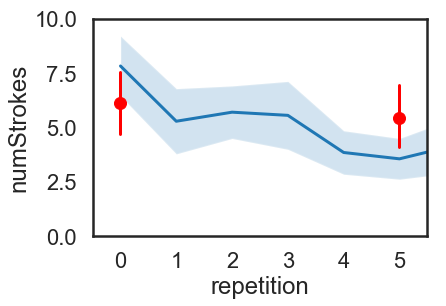

In [15]:
## conditioning on previous trial outcome being true 
D_true = D[D['previousOutcome'] == True]
reload(h)
dv = 'numStrokes'
h.ts_repeated_control(D_true, 
                        var=dv,
                        numReps = 6,
                        limit=10, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

### confusion matrix for each category

In [46]:
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.py:608: RuntimeWarning: invalid value encountered in divide
  normed[i,:] = confusion[i,:]/np.sum(confusion[i,:])


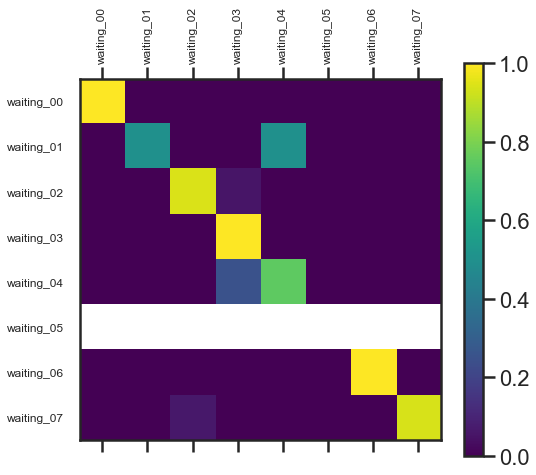

In [16]:
h.get_confusion_matrix(D, 'waiting', 4)

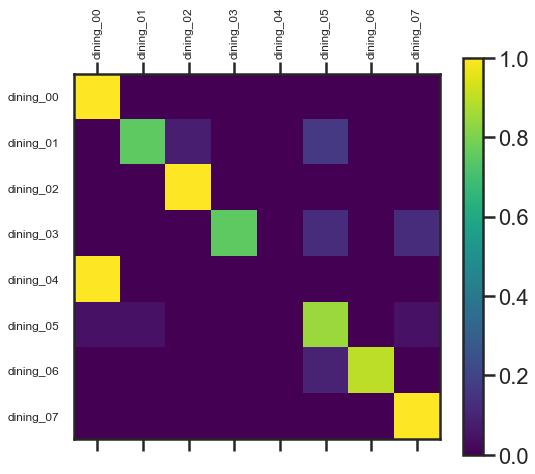

In [17]:
h.get_confusion_matrix(D, 'dining', 4)

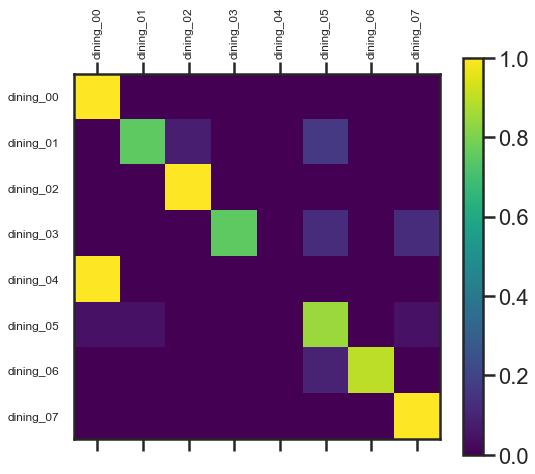

In [19]:
h.get_confusion_matrix(D, 'dining', 4)

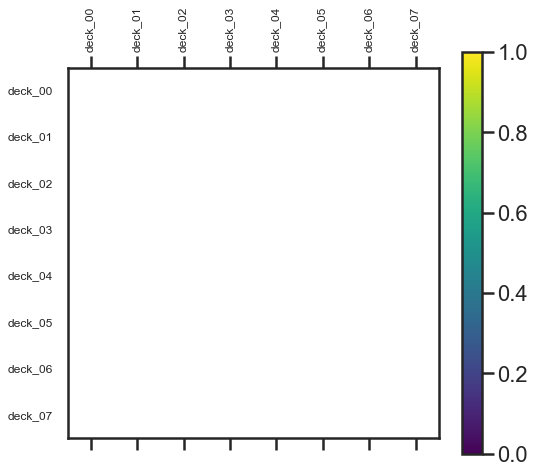

In [20]:
h.get_confusion_matrix(D, 'deck', 4)

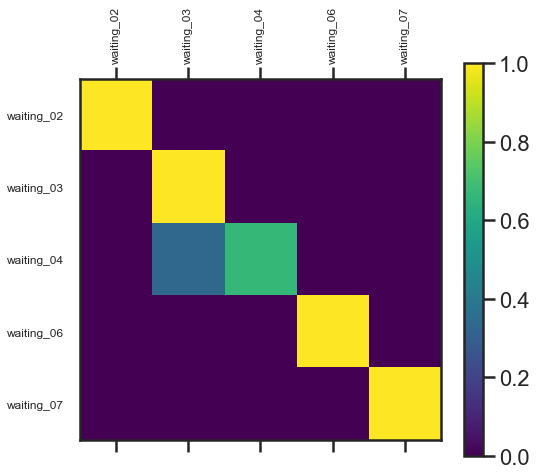

In [21]:
category = 'waiting'
set_size = 4

_D = D[D['condition'] == 'repeated']
_D = _D[_D['repetition'] >= 5]
target_list = _D['target'].tolist()
obj_list_ = []
obj_list = []
objlist = h.CATEGORY_TO_OBJECT_run2[category]
for obj in objlist[:set_size*2]:
    obj_list_.append(obj)
for i in obj_list_:
    if i in target_list:
        obj_list.append(i)

## initialize confusion matrix 
confusion = np.zeros((len(obj_list), len(obj_list)))

## generate confusion matrix by incrementing each cell 
for i, d in _D.iterrows():
    if d['category'] == category:
        targ_ind = obj_list.index(d['target'])
        chosen_ind = obj_list.index(d['response'])
        confusion[targ_ind, chosen_ind] += 1

## normalize confusion matrix 
normed = np.zeros((len(obj_list), len(obj_list)))
for i in np.arange(len(confusion)):
    normed[i,:] = confusion[i,:]/np.sum(confusion[i,:])

## plot confusion matrix 
from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(normed,vmin=0,vmax=1,cmap=cm.viridis)
plt.xticks(range(len(normed)), obj_list, fontsize=12,rotation='vertical')
plt.yticks(range(len(normed)), obj_list, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()
#plt.savefig('./plots/confusion_matrix_all.pdf')
#plt.close(fig)

## visualize behavioral measures over time

In [71]:
# reload analysis_helpers just to be on the safe side 
reload(h)

## set seaborn style params here
sns.set_context('poster')
sns.set_style('white')

##### Accuracy over time

In [22]:
total = 0
for outcome in D['outcome']:
    total = total + outcome 
meanAccuracy = total / len(D['outcome'])
meanAccuracy

0.89375000000000004

(0.5, 1.0)

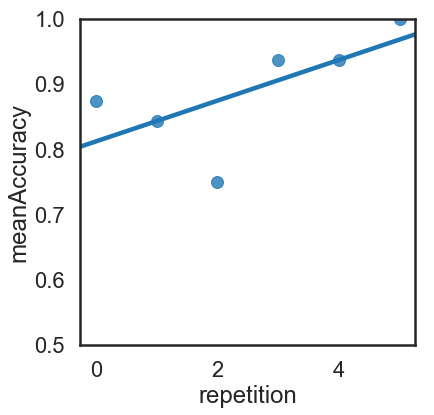

In [23]:
mean_accuracy_list = []
for i in range(0,6):
    outcome_list = (D.loc[D['repetition'] == i])['outcome']
    mean_accuracy = sum(outcome_list) / float(len(outcome_list))
    mean_accuracy_list.append(mean_accuracy)
D_mean = pd.DataFrame()
D_mean['meanAccuracy'] = mean_accuracy_list
D_mean['repetition'] = range(0,6)
D_mean
plt.figure(figsize=(6,6))
sns.regplot(data=D_mean,
         x='repetition',
         y='meanAccuracy',
         ci = None)    
plt.ylim([0.5,1.0])

In [24]:
D_correct = D[D['outcome'] == True]

In [25]:
(D_correct.groupby(['gameID','repetition','condition','category'])['numStrokes'].mean()).reset_index()

sns.lineplot(data=D_correct,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var0,
           estimator = None,
           ax=ax0,
           legend = False)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.xticks(np.arange(np.max(D0['repetition'])+1))

DataError: No numeric types to aggregate

### plot time series during repetition phase 

##### individual measures across reps (repeated trials only)

In [63]:
# What is the measure that you want to visualize across reps? 
dv = 'numCurvesPerSketch'

In [25]:
# D0 = h.ts_repeated(D,
#                                     var=dv,
#                                     limit=20, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
#                                     save_plot=False,
#                                     plot_dir=plot_dir)

##### individual measures across reps (repeated + control)

In [27]:
reload(h)
h.ts_repeated_control(D, 
                        var=dv,
                        numReps = 6,
                        limit=40, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

NameError: name 'dv' is not defined

##### 4 measures (2x2) across reps (repeated + control) 

In [26]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'numCurvesPerStroke'

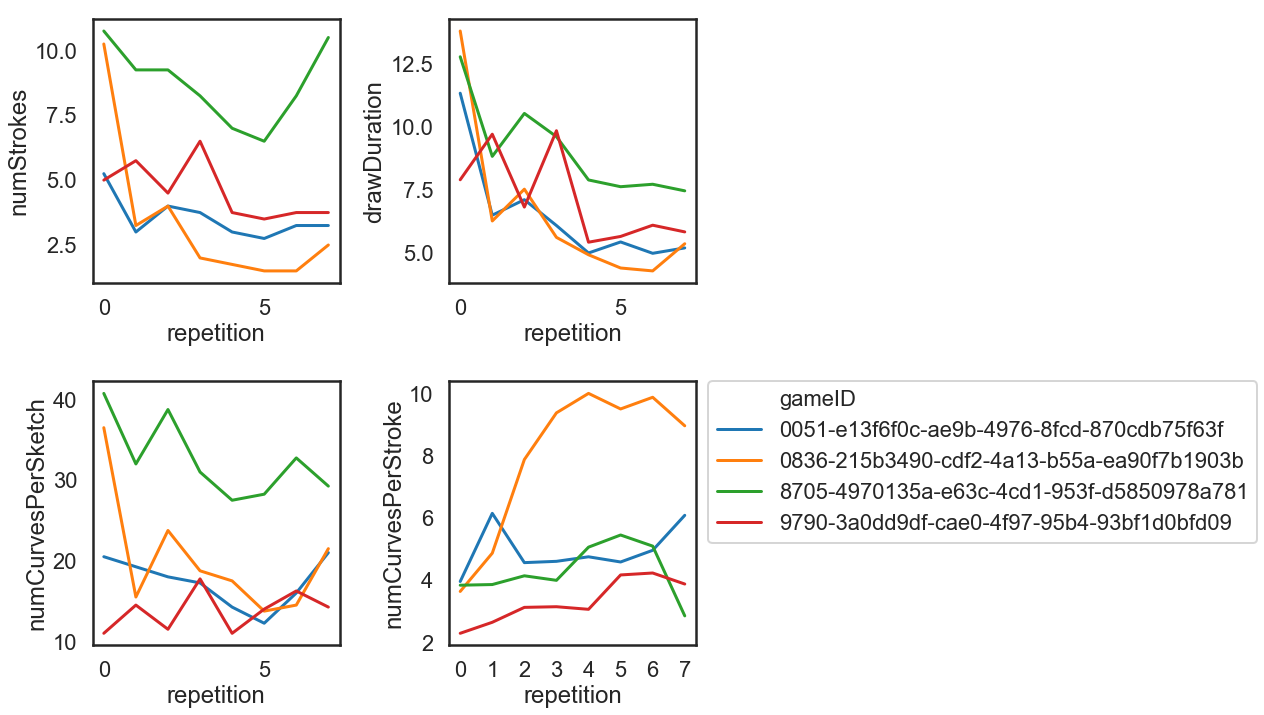

In [27]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

###  Subhelper 1

def collapse_within_repetition(D, var, condition, numReps):
    _D = D[D['condition']==condition]
    if condition == 'repeated':
        return (_D.groupby(['gameID','repetition','condition','category'])[var].mean()).reset_index()
    else: 
        return ((_D.groupby(['gameID','repetition','condition','category'])[var].mean()).reset_index()).replace(1,numReps-1)

D = convert_numeric(convert_numeric(convert_numeric(convert_numeric(D,var0),var1),var2),var3) 

## collapsing across objects within repetition (within pair) 
## and only aggregating repeated trials into this sub-dataframe
D0 = collapse_within_repetition(D, var0, 'repeated', 6)
D1 = collapse_within_repetition(D, var1, 'repeated', 6)
D2 = collapse_within_repetition(D, var2, 'repeated', 6)
D3 = collapse_within_repetition(D, var3, 'repeated', 6)

#fig = plt.figure(figsize=(12,12))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

## make sure that the number of timepoints now per gameID is equal to the number of repetitions in the game
num_reps = len(np.unique(D.repetition.values))
assert D0.groupby('gameID')['gameID'].count()[0]==num_reps    

sns.lineplot(data=D0,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var0,
           estimator = None,
           ax=ax0,
           legend = False)

sns.lineplot(data=D1,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var1,
           estimator = None,
           ax=ax1,
           legend = False)

sns.lineplot(data=D2,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var2,
           estimator = None,
           ax=ax2,
           legend = False)

sns.lineplot(data=D3,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var3,
           estimator = None,
           ax=ax3)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.xticks(np.arange(np.max(D0['repetition'])+1))
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [39]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'outcome'

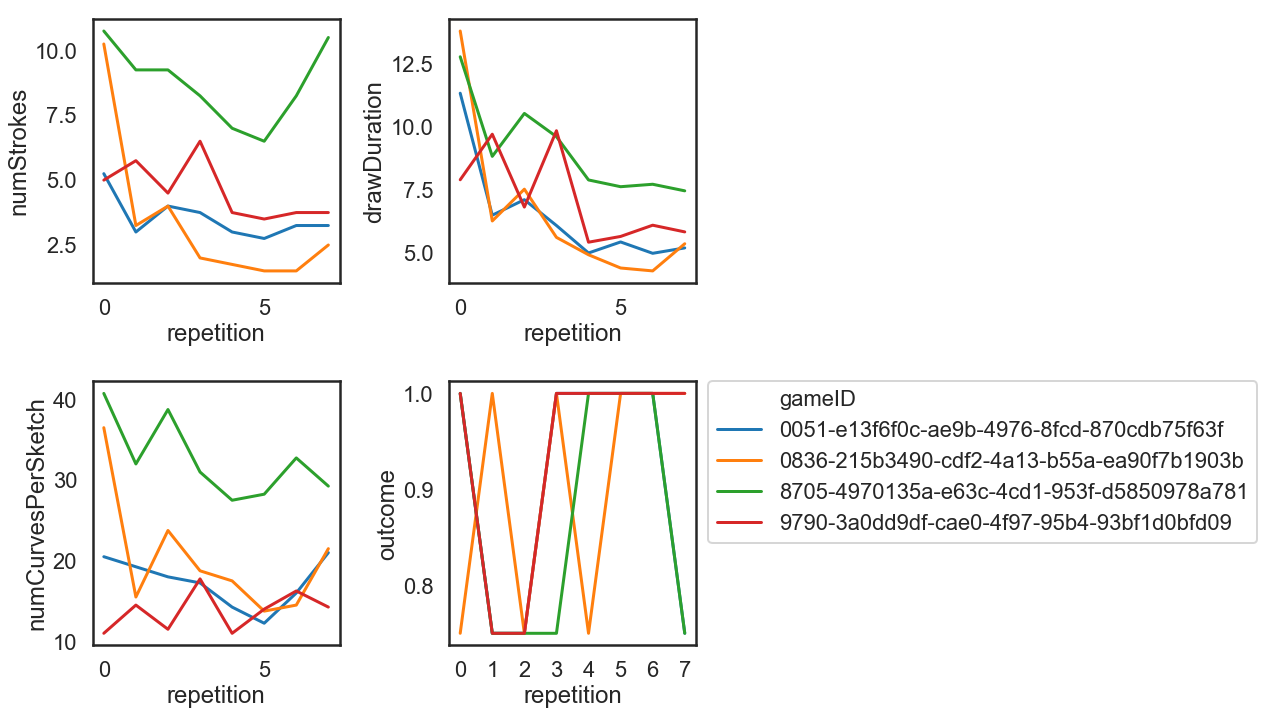

In [40]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

###  Subhelper 1

def collapse_within_repetition(D, var, condition, numReps):
    _D = D[D['condition']==condition]
    if condition == 'repeated':
        return (_D.groupby(['gameID','repetition','condition','category'])[var].mean()).reset_index()
    else: 
        return ((_D.groupby(['gameID','repetition','condition','category'])[var].mean()).reset_index()).replace(1,numReps-1)

D = convert_numeric(convert_numeric(convert_numeric(convert_numeric(D,var0),var1),var2),var3) 

## collapsing across objects within repetition (within pair) 
## and only aggregating repeated trials into this sub-dataframe
D0 = collapse_within_repetition(D, var0, 'repeated', 6)
D1 = collapse_within_repetition(D, var1, 'repeated', 6)
D2 = collapse_within_repetition(D, var2, 'repeated', 6)
D3 = collapse_within_repetition(D, var3, 'repeated', 6)

#fig = plt.figure(figsize=(12,12))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

## make sure that the number of timepoints now per gameID is equal to the number of repetitions in the game
num_reps = len(np.unique(D.repetition.values))
assert D0.groupby('gameID')['gameID'].count()[0]==num_reps    

sns.lineplot(data=D0,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var0,
           estimator = None,
           ax=ax0,
           legend = False)

sns.lineplot(data=D1,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var1,
           estimator = None,
           ax=ax1,
           legend = False)

sns.lineplot(data=D2,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var2,
           estimator = None,
           ax=ax2,
           legend = False)

sns.lineplot(data=D3,
           x='repetition',
           hue='gameID',
           units='gameID',
           y=var3,
           estimator = None,
           ax=ax3)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.xticks(np.arange(np.max(D0['repetition'])+1))
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future

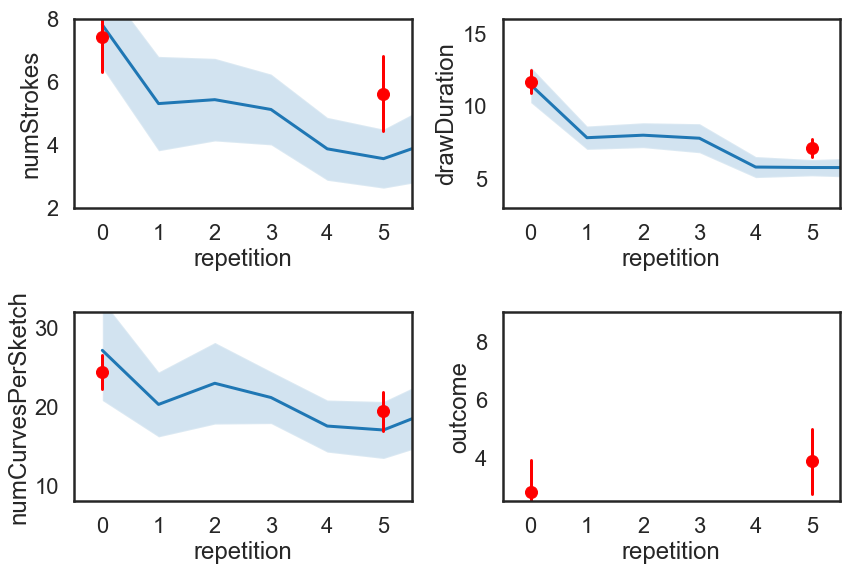

In [41]:
reload(h)
h.ts_grid_repeated_control(D, 
                                                var0, var1, var2, var3,
                                                numReps=6,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

### compare conditions in pre and post phases 

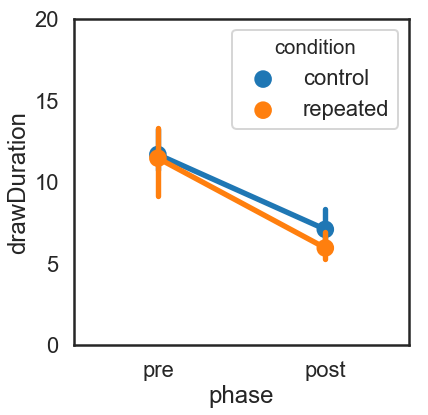

In [30]:
D1 = h.compare_conditions_prepost(D,
                                var='drawDuration',
                                limit=20,
                                save_plot=False,
                                plot_dir=plot_dir)

##### compare accuracy in pre and post phases (repeated vs control conditions)

In [31]:
for i, o in enumerate(D['outcome']):
    if o == True:
        D.set_value(i, 'outcome', 1)
    else:
        D.set_value(i, 'outcome', 0)
D['outcome'] = D['outcome'].astype(int)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 1.1)

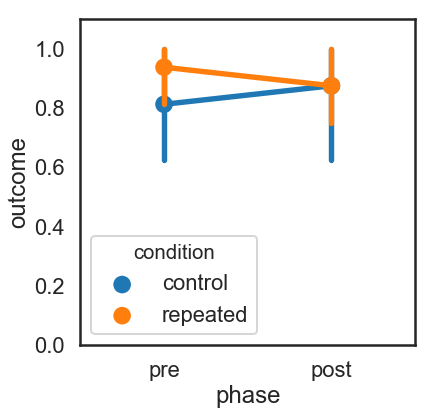

In [32]:
_D1 = D[D['phase']!='repeated'] ## exclude "repetition-phase" trials
D1 = _D1.groupby(['gameID','phase','condition'])['outcome'].mean()
D1 = D1.reset_index()    

plt.figure(figsize=(6,6))
sns.pointplot(data=D1,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,1.1])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1    

 ### visualize how sketches are changing across repetitions

In [17]:
# print_repeated_sketches(D,
#                                      complete_games,
#                                      sketch_dir)

In [18]:
# print_control_sketches(D,
#                                    complete_games,
#                                    sketch_dir)

##### printing actual sketches next to repeated sketches

In [38]:
index = list(range(1, 37))
new_index = filter(lambda x: x%9!=0, index)

Printing out sketches from game: 0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b
Printing out sketches from game: 8705-4970135a-e63c-4cd1-953f-d5850978a781
Printing out sketches from game: 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f
Printing out sketches from game: 9790-3a0dd9df-cae0-4f97-95b4-93bf1d0bfd09


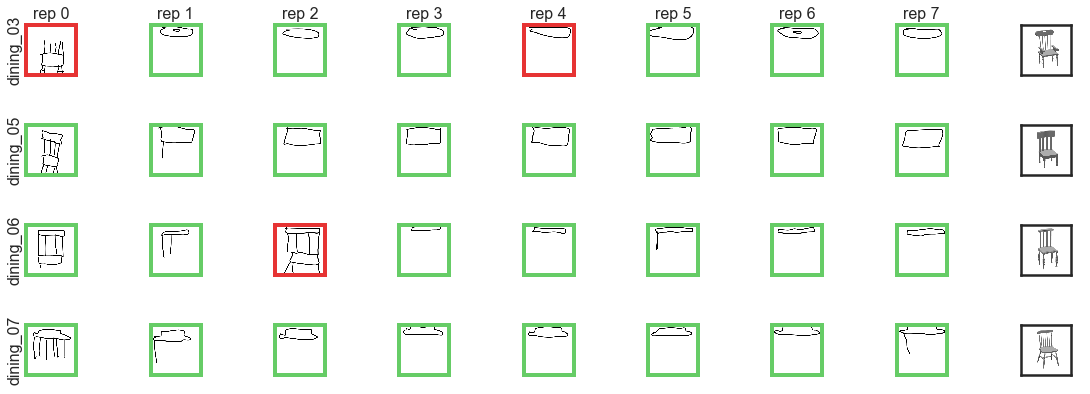

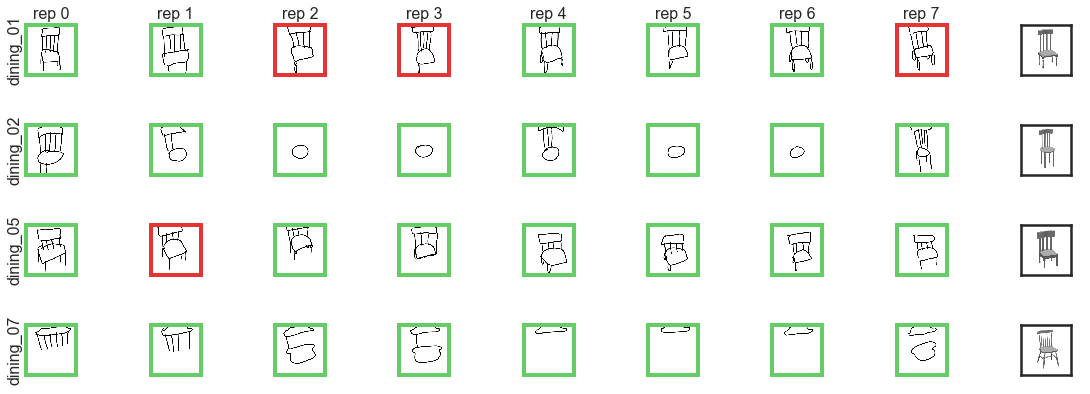

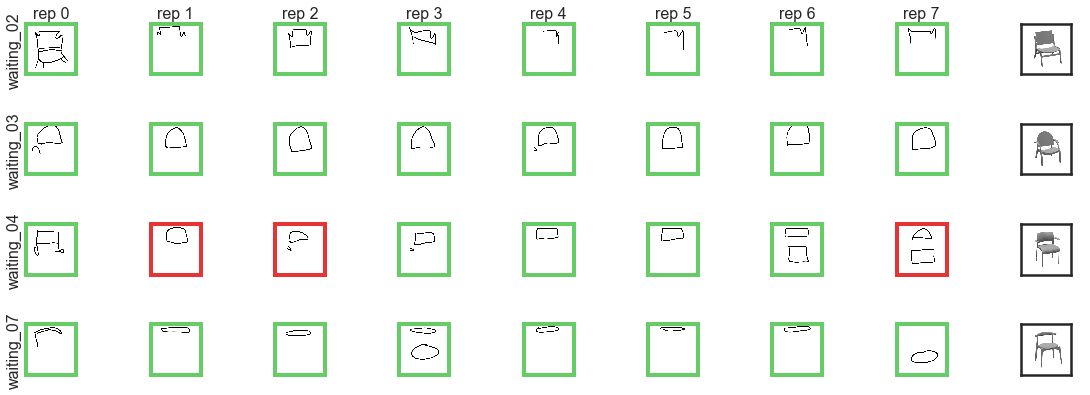

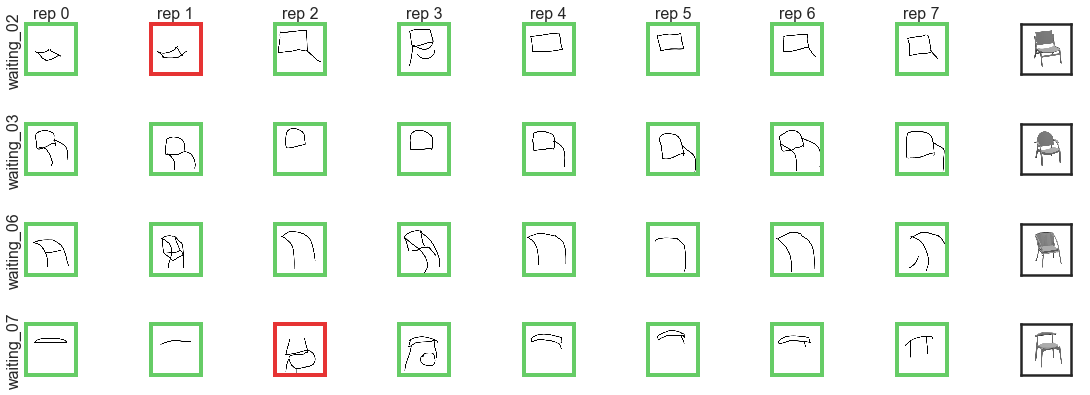

In [35]:
for g in complete_games:
    print 'Printing out sketches from game: ' + g
    trial_types = ['repeated']
    for tt in trial_types:
        _D = D[(D.condition=='repeated') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 0
        textsize=12
        fig = plt.figure(figsize=(16,6))
        for i,_d in _D.iterrows():
            true_index = new_index[_i]
            if _i %8 == 0:
                target = _d['target']
                dir_path = 'chairs1k_pilot'
                png_name = target + '.png'
                path = os.path.join(dir_path, png_name)
                im = Image.open(path)
                cropped_im = im.crop((350, 150, 600, 400))
                p = plt.subplot(4,9,true_index+8)
                plt.imshow(cropped_im)
                sns.set_style('white')
                k = p.get_xaxis().set_ticklabels([])
                k = p.get_yaxis().set_ticklabels([])
                k = p.get_xaxis().set_ticks([])
                k = p.get_yaxis().set_ticks([]) 
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(4,9,true_index)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            category = _d['category']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i < 8) & (tt in 'repeated'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
            if _i%8==0:
                plt.ylabel(_d['target'] ,fontsize=textsize)
            
                

            _i  = _i + 1

        filepath = os.path.join(sketch_dir,'repeated','{}_{}.pdf'.format(g,category))                                                                
        if not os.path.exists(os.path.join(sketch_dir,'repeated')):
            os.makedirs(os.path.join(sketch_dir,'repeated'))
        plt.tight_layout()

In [297]:
D_ = D[(D.condition=='control') & (D.gameID=='9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993')]
D__ = D_[(D_.phase == 'post')]
D__['outcome']

39    1
41    0
42    1
43    1
44    1
47    0
Name: outcome, dtype: int64

##### printing last sketch of control condition next to repeated sketches 

Printing out sketches from game: 0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b


IndexError: single positional indexer is out-of-bounds

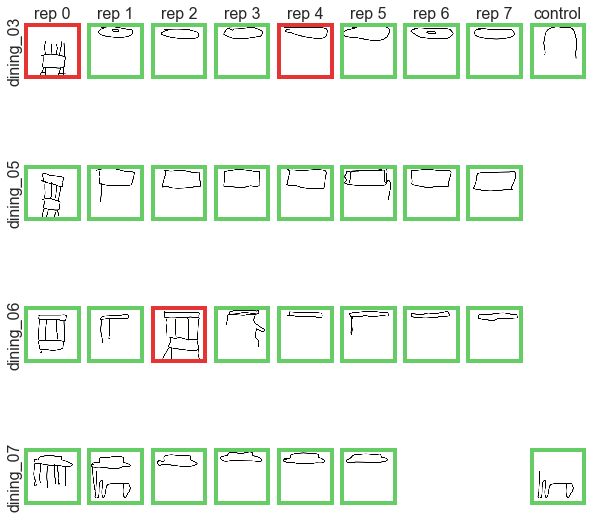

In [37]:
for g in complete_games:
    print 'Printing out sketches from game: ' + g
    trial_types = ['repeated']
    for tt in trial_types:
        _D = D[(D.condition=='repeated') & (D.gameID==g)]
        D_ = D[(D.condition=='control') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 0
        control_index = 0
        textsize=12
        fig = plt.figure(figsize=(10,10))
        for i,_d in _D.iterrows():
            true_index = new_index[_i]
            if _i %6 == 0:
                # plot last of control sketch 
                target = _d['target']
                D__ = D_[D_.phase == 'post']
                imgData = D__['png'].iloc[control_index]
                filestr = base64.b64decode(imgData)
                fname = 'sketch.png'
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                textsize = 16
                # first plot the target
                im = Image.open(fname)
                p = plt.subplot(4,9,true_index+8)
                plt.imshow(im)
                if (_i < 6):
                    plt.title('control' ,fontsize=textsize)
                sns.set_style('white')
                k = p.get_xaxis().set_ticklabels([])
                k = p.get_yaxis().set_ticklabels([])
                k = p.get_xaxis().set_ticks([])
                k = p.get_yaxis().set_ticks([]) 
                outcome = D__['outcome'].iloc[control_index]
                if outcome == 1:
                    sides = ['bottom','top','right','left']
                    for s in sides:
                        p.spines[s].set_color((0.4,0.8,0.4))
                        p.spines[s].set_linewidth(4)                               
                else:
                    sides = ['bottom','top','right','left']
                    for s in sides:
                        p.spines[s].set_color((0.9,0.2,0.2))
                        p.spines[s].set_linewidth(4)    
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(4,9,true_index)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            category = _d['category']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i < 8) & (tt in 'repeated'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
            if _i%8==0:
                plt.ylabel(_d['target'] ,fontsize=textsize)
                control_index = control_index + 1
                
            _i  = _i + 1

        filepath = os.path.join(sketch_dir,'repeated','{}_{}.pdf'.format(g,category))                                                                
        if not os.path.exists(os.path.join(sketch_dir,'repeated')):
            os.makedirs(os.path.join(sketch_dir,'repeated'))
        plt.tight_layout()

##### printing control sketches

Printing out sketches from game: 9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993
Printing out sketches from game: 8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73
Printing out sketches from game: 9340-a1124706-24cc-44f3-9097-ba0b33adbf36
Printing out sketches from game: 3511-727c76f4-f755-48e9-8fc8-b61efbe785c9


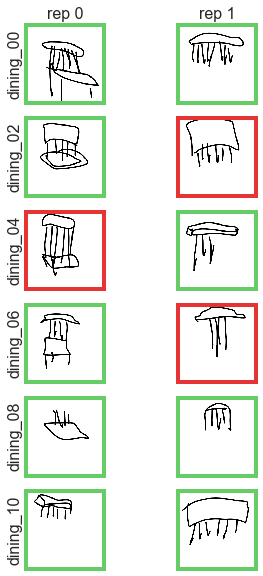

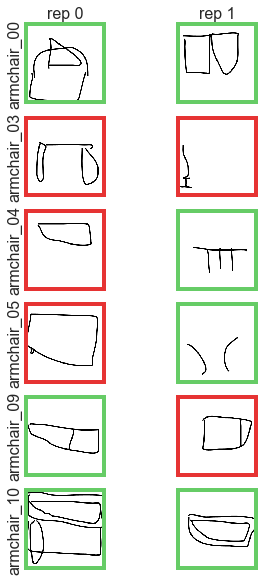

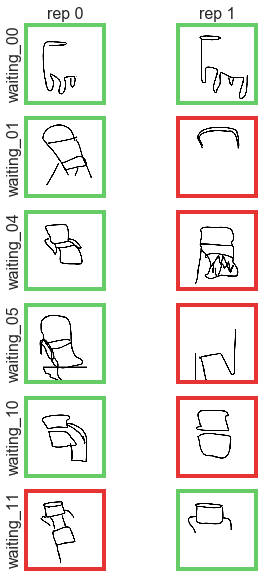

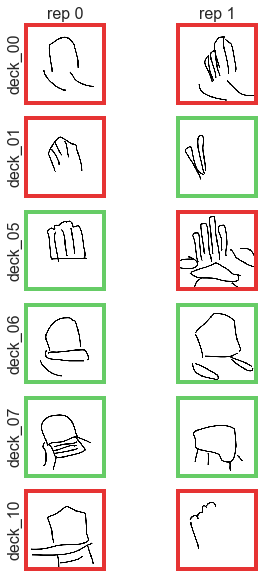

In [137]:
_valid_gameids = complete_games

for g in _valid_gameids:
    print 'Printing out sketches from game: ' + g
    trial_types = ['control']
    for tt in trial_types:
        _D = D[(D.condition=='control') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(5,10))
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(6,2,_i)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            category = _d['category']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i-1 < 2) & (tt in 'control'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
            if (_i-1)%2==0:
                plt.ylabel(_d['target'] ,fontsize=textsize)

            _i  = _i + 1

        filepath = os.path.join(sketch_dir,'control','{}_{}.pdf'.format(g,category))     
        if not os.path.exists(os.path.join(sketch_dir,'control')):
            os.makedirs(os.path.join(sketch_dir,'control'))
        #plt.savefig(os.path.join(sketch_dir,'control',filepath))
        #plt.close(fig)

### WORKING AREA

In [ ]:
## collapsing across objects within repetition (within pair) 
D0_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var0].mean()).reset_index()
D1_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var1].mean()).reset_index()
D2_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var2].mean()).reset_index()
D3_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var3].mean()).reset_index()

D0_control = ((D_control.groupby(['gameID','repetition','condition'])[var0].mean()).reset_index()).replace(1, 7) # rescale control reps 
D1_control = ((D_control.groupby(['gameID','repetition','condition'])[var1].mean()).reset_index()).replace(1, 7) # rescale control reps 
D2_control = ((D_control.groupby(['gameID','repetition','condition'])[var2].mean()).reset_index()).replace(1, 7) # rescale control reps 
D3_control = ((D_control.groupby(['gameID','repetition','condition'])[var3].mean()).reset_index()).replace(1, 7) # rescale control reps 

In [ ]:

# sns.tsplot(data=D0_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var0,
#            ax=ax0)

# sns.tsplot(data=D0_control,
#                time='repetition',
#                unit='gameID',
#                value=var0,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax0,
#                color='r')

# sns.tsplot(data=D1_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var1,
#            ax=ax1)

# sns.tsplot(data=D1_control,
#                time='repetition',
#                unit='gameID',
#                value=var1,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax1,
#                color='r')

# sns.tsplot(data=D2_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var2,
#            ax=ax2)

# sns.tsplot(data=D2_control,
#                time='repetition',
#                unit='gameID',
#                value=var2,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax2,
#                color='r')

# sns.tsplot(data=D3_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var3,
#            ax=ax3)

# sns.tsplot(data=D3_control,
#                time='repetition',
#                unit='gameID',
#                value=var3,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax3,
#                color='r')

# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# ax0.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax1.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax2.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax3.set(xlim=(-0.5, 7.5), xticks=range(0,8))

In [ ]:
# for i in range(0, 4):
#     var = 'var'+ i
#     print var
#     'D' + str(i) + '_' + condition = collapse_within_repetition(D, var, condition)

In [ ]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

D = convert_numeric(convert_numeric(convert_numeric(convert_numeric(D,var0),var1),var2),var3) 

def collapse_within_repetition(D, var, condition):
    _D = D[D['condition']==condition]
    if condition == 'repeated':
        return (_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()
    else: 
        return ((_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()).replace(1,7)
    
def plot_repeated_control(D_repeated, D_control, var, ax):
    sns.tsplot(data=D_repeated,
           time='repetition',
           unit='gameID',
           value=var,
           ax=ax)

    sns.tsplot(data=D_control,
               time='repetition',
               unit='gameID',
               value=var,
               err_style='ci_bars',
               interpolate=False,
               ax=ax,
               color='r')
    
    ax.set(xlim=(-0.5, 7.5), xticks=range(0,8))

In [ ]:
_newD = pd.DataFrame()

target = d['target']
link = 'https://s3.amazonaws.com/shapenet-graphical-conventions/52f0514f5c38bc96f51f77a6d7299806.png'
extra_row = [link] * D.shape[1]
extra_df = pd.DataFrame(extra_row, index = list(D.columns.values))
extra_df = extra_df.transpose()
extra_df

_newD = pd.concat([_newD, extra_df])

In [ ]:
newD = pd.DataFrame()
for i, d in D.iterrows():
    d = d.to_frame()
    d = d.transpose()
    if i%6 == 0 & i != 0:
        newD = pd.concat([newD, d])
        target = d['target']
        link = 'https://s3.amazonaws.com/shapenet-graphical-conventions/52f0514f5c38bc96f51f77a6d7299806.png'
        extra_row = [link] * D.shape[1]
        extra_df = pd.DataFrame(extra_row, index = list(D.columns.values))
        extra_df = extra_df.transpose()
        newD = pd.concat([newD, extra_df])
    else:
        newD = pd.concat([newD, d])

# Miscellaneous

In [ ]:
#seaborn plotting

d = pd.DataFrame()
numReps = 7
variable = 'numStrokes'
# repeated conditions 
criteria_repeated = (D['condition']=='repeated')
repeated = D[criteria_repeated] # get all repeated condition trials 
repeats = list(range(0, numReps)) # number of repeats
repeated_means = []
for rep in repeats:
    mean = ((repeated[(repeated['repetition'] == rep)])[variable]).mean()  # get mean across trials with same repetition number
    repeated_means.append(mean)

# control conditions 
criteria_control = (D['condition']=='control')
control = D[criteria_control] # get all control condition trials 
controls = [0, numReps - 1] # number of controls scaled up to total number of repeats 
control_means= []
for i in [0, 1]: # only 2 controls, but should scale up to numReps 
    mean = ((control[(control['repetition'] == i)])[variable]).mean() # get mean across trials with same repetition number
    control_means.append(mean)

d['numReps'] = repeats
d[variable] = repeated_means
#d['control'] = control_means
facet = sns.lmplot(data=d, x='numReps', y=variable, fit_reg=False)
# add error bars 

In [ ]:
print repeated_strokes.mean(), control_strokes.mean()
print repeated_svgLength.mean(), control_svgLength.mean()
print repeated_svgStd.mean(), control_svgStd.mean()
print repeated_svgLengthPS.mean(), control_svgLengthPS.mean()
print repeated_drawDuration.mean(), control_drawDuration.mean()
print repeated_accuracy.mean(), control_accuracy.mean()

NameError: name 'control_strokes' is not defined

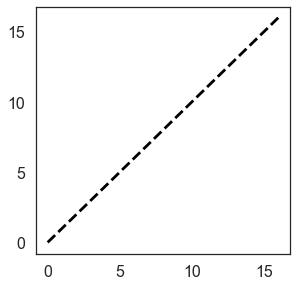

In [16]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_strokes,repeated_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLength,repeated_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgStd,repeated_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,4)
lb = 0
ub = 600
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLengthPS,repeated_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('control')
plt.ylabel('repeated')

In [ ]:
a = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}, {'time':{'$gt':1531160581750, '$lt': 1531161932801}}]}).sort('time')
for rec in a:
    print rec['phase'], rec['condition'],rec['repetition']